In [1]:
import numpy as np
from torch import Tensor
from src.datasets.shakespeare.shakespeare import ShakespeareDataset
from torch.nn import functional as F
from src.training.discrete_loss import (
    #alpha_variance_loss,
    divergence_loss,
    format_loss,
    loss,
    variance_loss,
)

In [2]:
import os

import torch
from accelerate import Accelerator
from matplotlib import pyplot as plt
from safetensors.torch import load_file
from tqdm.auto import tqdm

from src.datasets.discrete_helper import collate_fn
from src.inference.discrete_inference import bayesian_inference, dis_t
from src.nn.layers.learnable_schedule import LearnableBetaScheduleNI
from src.nn.models.discrete_model import DiscreteModel
from src.tokenizers.ascii.ascii_tokenizer import ASCIITokenizer as Tokenizer
from src.training.checkpoint import CheckpointManager, CheckpointMetadata
from src.training.training import train_discrete_model

accelerator = Accelerator(project_dir="./runs/shakespeare")
tokenizer = Tokenizer()
max_seq_len = 32
folds = 8
dataset = ShakespeareDataset(
    tokenizer=tokenizer, max_length=max_seq_len, folds=folds,
)

model_kwargs = {
    "max_seq_len": max_seq_len,
    "K": tokenizer.vocab_size(),
    "hidden_dim": 512,
    "num_heads": 8,
    "layers": 5,
    # beta_1 from https://arxiv.org/html/2407.20294v2 equation 5
    "reference_beta_1": 20.4054 / tokenizer.vocab_size(),
    "learner_weight": 1.0,
    "freeze_body": False,
}
model = DiscreteModel(**model_kwargs)

optimizer_kwargs = {
    "lr": 3e-5,
}
body_opt = torch.optim.Adam(
    model.body.parameters(), **optimizer_kwargs  # pyright: ignore[reportArgumentType]
)
schedule_opt = torch.optim.Adam(
    model.learnable_beta.parameters(),
    **optimizer_kwargs,  # pyright: ignore[reportArgumentType]
)

metadata = CheckpointMetadata(
    model_kwargs=model_kwargs,
    optimizer_kwargs=optimizer_kwargs,
    is_fsdp=hasattr(accelerator.state, "fsdp_plugin")
    and accelerator.state.fsdp_plugin is not None,
    num_accelerators=accelerator.num_processes,
)

checkpoint_dir = "./checkpoint/shakespeare_shannon_ASCII"
checkpoint_manager = CheckpointManager()
print("Preparing model...")
checkpoint_manager.prepare(model, body_opt, schedule_opt, accelerator, metadata)
print("Starting checkpoint loading process...")
checkpoint_manager.load(checkpoint_dir, error_if_not_exists=True)
print("Finished loading checkpoint")

model, opt = checkpoint_manager.model, checkpoint_manager.body_optimizer

assert model is not None

schedule: LearnableBetaScheduleNI = model.learnable_beta

assert isinstance(schedule, LearnableBetaScheduleNI)

Using the latest cached version of the module from /media/john/Tertiary/Data/huggingface/modules/datasets_modules/datasets/karpathy--tiny_shakespeare/b5b13969f09fe8707337f6cb296314fbe06960bd9a868dca39e713e163d27b5e (last modified on Sun Jul 20 14:43:33 2025) since it couldn't be found locally at karpathy/tiny_shakespeare, or remotely on the Hugging Face Hub.


Preparing model...
Starting checkpoint loading process...
Attempting to load checkpoint from epoch 331200
Finished loading checkpoint


In [3]:
for param in model.parameters():
    if torch.isnan(param).any():
        raise ValueError("NaN detected in model parameters after loading checkpoint")

In [4]:
device = accelerator.device

/media/john/Tertiary/Projects/ML/BayesianFlowNet/.venv/lib/python3.11/site-packages/torch/nn/modules/linear.py:125: UserWarning: Attempting to use hipBLASLt on an unsupported architecture! Overriding blas backend to hipblas (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:310.)
  return F.linear(input, self.weight, self.bias)


Learnt beta_1: 0.2180, Scaling: 0.2425, Alpha std: 0.0923


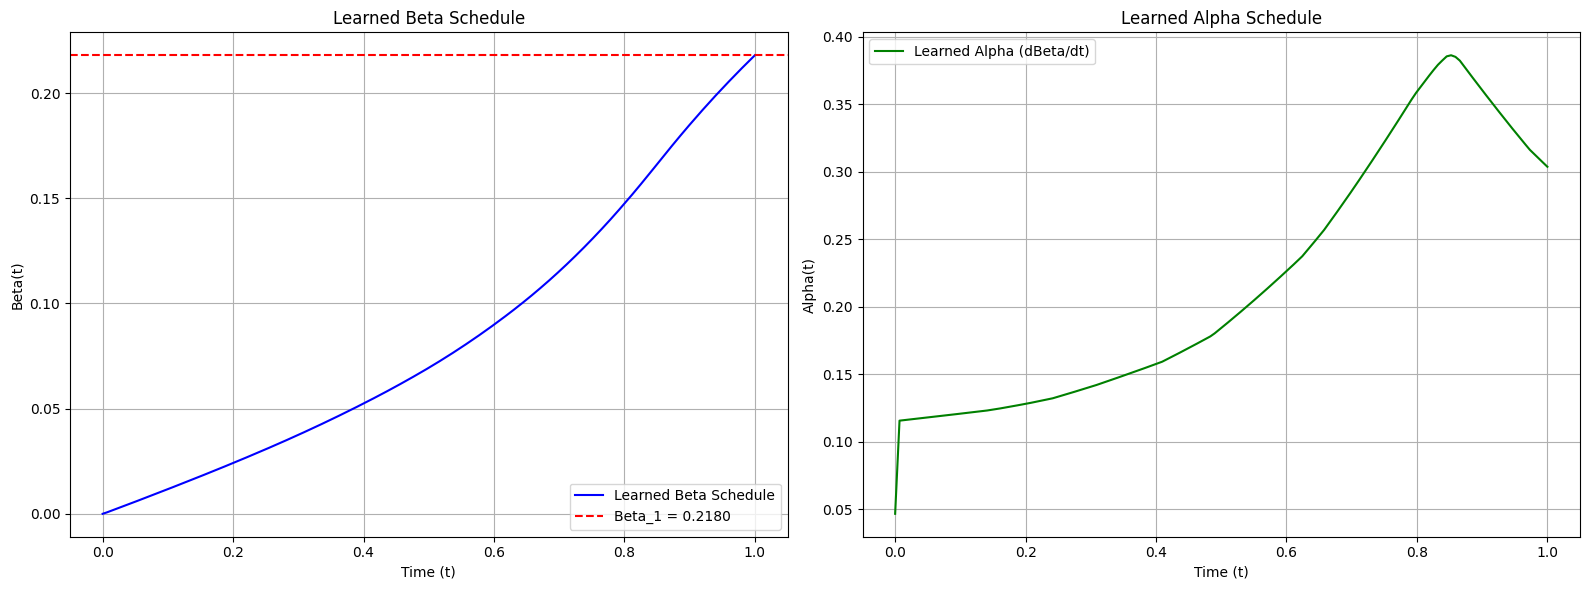

In [5]:
beta_scheduler = model.learnable_beta
t_coords, beta_coords = beta_scheduler.visualize(K=tokenizer.vocab_size(), points=150, device=device)
alpha_t_coords, alpha_coords = beta_scheduler.visualize_alpha(K=tokenizer.vocab_size(), points=150, device=device)
learnt_beta_1 = model.beta_1(K=tokenizer.vocab_size(), device=device)
scaling = model.scaling(tokenizer.vocab_size(), device=device)

print(f"Learnt beta_1: {learnt_beta_1:.4f}, Scaling: {scaling:.4f}, Alpha std: {np.std(alpha_coords):.4f}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Beta schedule
ax1.plot(t_coords, beta_coords, label='Learned Beta Schedule', color='blue')
ax1.axhline(y=learnt_beta_1, color='red', linestyle='--', label=f'Beta_1 = {learnt_beta_1:.4f}')
ax1.set_xlabel('Time (t)')
ax1.set_ylabel('Beta(t)')
ax1.set_title('Learned Beta Schedule')
ax1.legend()
ax1.grid(True)

# Alpha schedule
ax2.plot(alpha_t_coords, alpha_coords, label='Learned Alpha (dBeta/dt)', color='green')
ax2.set_xlabel('Time (t)')
ax2.set_ylabel('Alpha(t)')
ax2.set_title('Learned Alpha Schedule')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

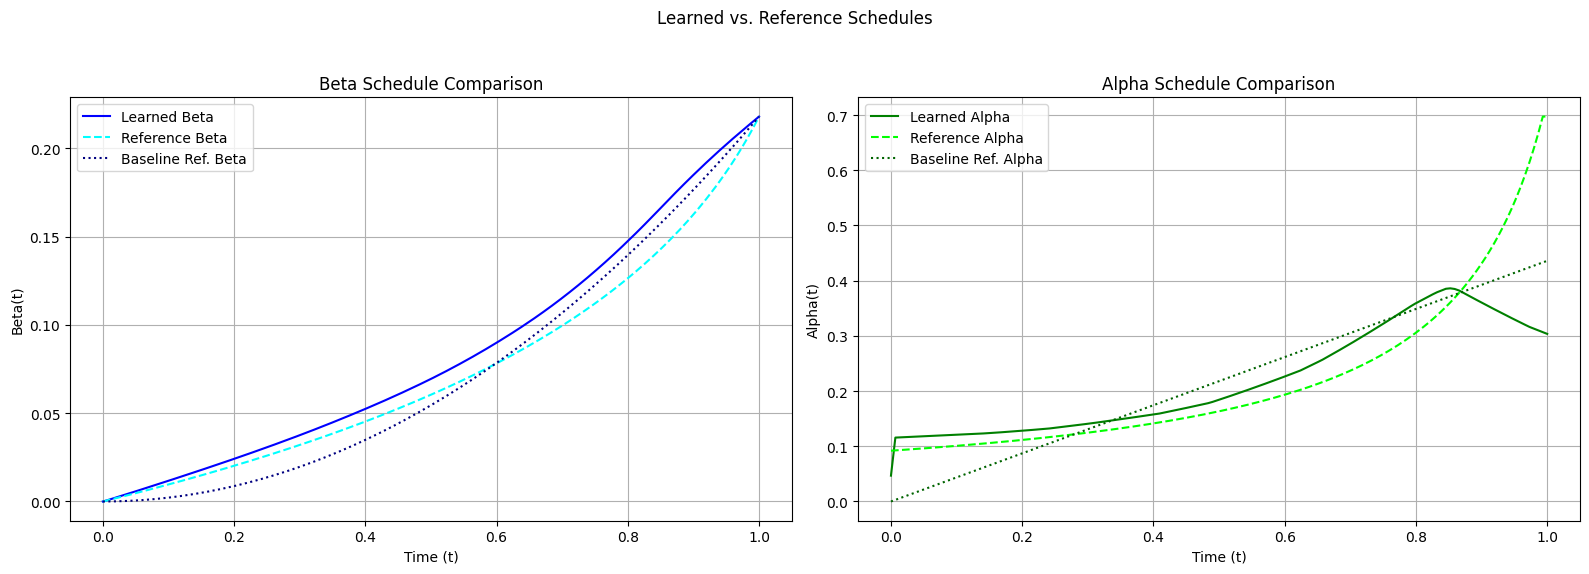

In [6]:
# from chem bfn paper
def reference_beta_schedule(t: Tensor, K: int, beta_1: float) -> Tensor:
    return (- 4 / K) * torch.log(1 - t + t * torch.exp(- K * beta_1 / 4))
def reference_alpha_schedule(t: Tensor, K: int, beta_1: float) -> Tensor:
    return (4 / K) * ((1 - torch.exp(-K * beta_1 / 4)) / (1 - t + t * torch.exp(-K * beta_1 / 4)))

# from original bfn paper
def reference_beta_schedule_baseline(t: Tensor, K: int, beta_1: float) -> Tensor:
    return beta_1 * (t ** 2)
def reference_alpha_schedule_baseline(t: Tensor, K: int, beta_1: float) -> Tensor:
    return beta_1 * 2 * t

ref_beta = reference_beta_schedule(torch.as_tensor(t_coords), tokenizer.vocab_size(), torch.tensor([learnt_beta_1]))
ref_alpha = reference_alpha_schedule(torch.as_tensor(alpha_t_coords), tokenizer.vocab_size(), torch.tensor([learnt_beta_1]))
ref_alpha[-1] = ref_alpha[-2]  # avoid tiny numerical issues at t=1, the graph looks useless otherwise
ref_beta_baseline = reference_beta_schedule_baseline(torch.as_tensor(t_coords), tokenizer.vocab_size(), torch.tensor([learnt_beta_1]))
ref_alpha_baseline = reference_alpha_schedule_baseline(torch.as_tensor(alpha_t_coords), tokenizer.vocab_size(), torch.tensor([learnt_beta_1]))
# t_coords, beta_coords, ref_beta
# alpha_t_coords, alpha_coords, ref_alpha
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Learned vs. Reference Schedules')

# Beta schedule comparison
ax1.plot(t_coords, beta_coords, label='Learned Beta', color='blue')
ax1.plot(t_coords, ref_beta.numpy(), label='Reference Beta', color='cyan', linestyle='--')
ax1.plot(t_coords, ref_beta_baseline.numpy(), label='Baseline Ref. Beta', color='navy', linestyle=':')
ax1.set_xlabel('Time (t)')
ax1.set_ylabel('Beta(t)')
ax1.set_title('Beta Schedule Comparison')
ax1.legend()
ax1.grid(True)

# Alpha schedule comparison
ax2.plot(alpha_t_coords, alpha_coords, label='Learned Alpha', color='green')
ax2.plot(alpha_t_coords, ref_alpha.numpy(), label='Reference Alpha', color='lime', linestyle='--')
ax2.plot(alpha_t_coords, ref_alpha_baseline.numpy(), label='Baseline Ref. Alpha', color='darkgreen', linestyle=':')
ax2.set_xlabel('Time (t)')
ax2.set_ylabel('Alpha(t)')
ax2.set_title('Alpha Schedule Comparison')
ax2.legend()
ax2.grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Variance of losses: 0.7209, Standard Deviation: 0.8491


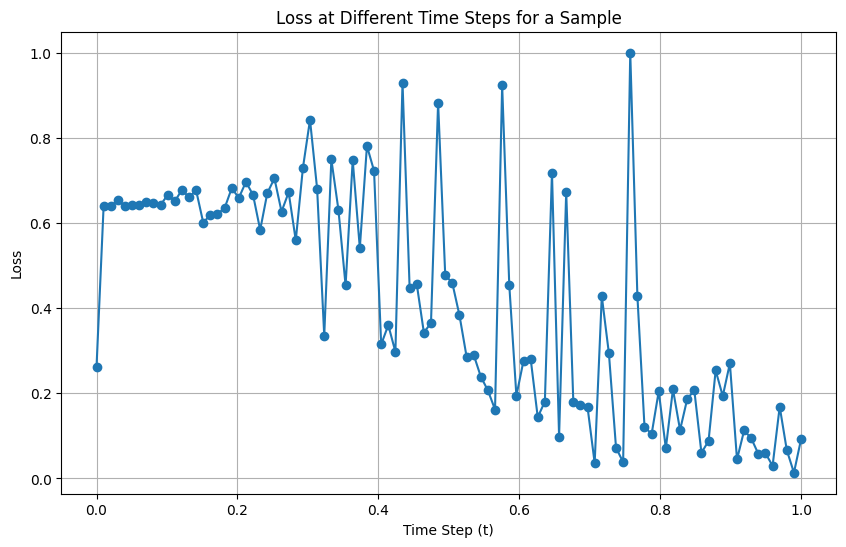

In [7]:
# with torch.no_grad():
# here we take a random sample from the dataset and repeat it on different time steps to see if the loss is uniform at each time step
sample = dataset[0]
sampled_x = sample["x"].unsqueeze(0).to(device)  # Add batch
sampled_x = F.one_hot(sampled_x, num_classes=tokenizer.vocab_size())
sampled_t = torch.linspace(0, 1, 100).to(device) + 1e-8 # Add 100 time steps, prevent 0 using small epsilon
sampled_losses = []
for t in sampled_t:
    sample_output, sample_alpha = model.forward(sampled_x, t.unsqueeze(0))
    # Calculate loss for each time step
    formatted_loss = format_loss(
                sample_alpha, sampled_x, model_output_logits=sample_output, folds=1
    )
    sample_loss = loss(formatted_loss)
    sampled_losses.append(sample_loss.cpu().item())
sampled_losses = np.array(sampled_losses)

print(
    f"Variance of losses: {np.var(sampled_losses):.4f}, Standard Deviation: {np.std(sampled_losses):.4f}"
)

sampled_losses = sampled_losses / sampled_losses.max()
plt.figure(figsize=(10, 6))
plt.plot(sampled_t.cpu().detach().numpy(), sampled_losses, marker='o', linestyle='-')
plt.xlabel('Time Step (t)')
plt.ylabel('Loss')
plt.title('Loss at Different Time Steps for a Sample')
plt.grid(True)
plt.show()

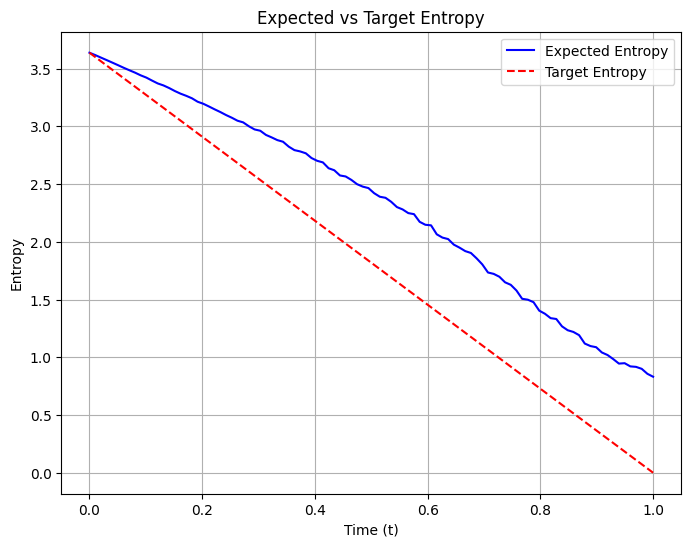

In [8]:
from math import log
from torch.distributions import Categorical
from src.datasets.discrete_helper import y_distribution
import einops

with torch.no_grad():
    # here we take a random sample from the dataset and see what the entropy of the perturbed version is
    sample = dataset[0]
    sampled_x = sample["x"].unsqueeze(0).to(device)  # Add batch
    sampled_x = F.one_hot(sampled_x, num_classes=tokenizer.vocab_size())
    
    t_coords = torch.linspace(0, 1, 100, device=device)
    
    K = tokenizer.vocab_size()
    samples = 64 # Number of Monte Carlo samples
    
    # Repeat for MC sampling
    sampled_x_repeated = einops.repeat(sampled_x, 'b s k -> (b samples) s k', samples=samples)
    
    entropies_over_t = []
    for t in t_coords:
        t_repeated = t.expand(samples)
        beta_t = schedule(t_repeated, K)
        
        # Get logits for each sample
        beta_t_dist = y_distribution(beta_t, K, sampled_x_repeated)
        beta_cat = Categorical(logits=beta_t_dist)
        
        # Calculate entropy and average over samples
        entropy = beta_cat.entropy() # Shape: (samples, seq_len)
        expected_entropy_for_t = torch.mean(entropy) # Average over samples and seq_len
        entropies_over_t.append(expected_entropy_for_t.cpu().item())

    target_entropy = log(K) * (1 - t_coords)

    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.plot(t_coords.cpu().numpy(), entropies_over_t, label='Expected Entropy', color='blue')
    ax.plot(t_coords.cpu().numpy(), target_entropy.cpu().numpy(), label='Target Entropy', color='red', linestyle='--')
    ax.set_xlabel('Time (t)')
    ax.set_ylabel('Entropy')
    ax.set_title('Expected vs Target Entropy')
    ax.legend()
    ax.grid(True)
    plt.show()